In [1]:
import os
import sys

In [2]:
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/Insurance_claims_data.csv')

print(df.shape)
df.head()

test_df = df.sample(20000, random_state=23)

# Create train/test split with stratification since data is imbalanced
X = test_df.drop('claim_status', axis=1)
y = test_df['claim_status']

# Use stratify parameter to maintain class distribution in both splits
# Use test_size=0.2 for 80/20 split which is common practice
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42, # For reproducibility
    stratify=y # Maintain class distribution
)

# Print shapes to verify split
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("\nClass distribution in splits:")
print("Training set:", pd.Series(y_train).value_counts(normalize=True))
print("Test set:", pd.Series(y_test).value_counts(normalize=True))


(58592, 41)
Training set shape: (16000, 40)
Test set shape: (4000, 40)

Class distribution in splits:
Training set: claim_status
0    0.935063
1    0.064937
Name: proportion, dtype: float64
Test set: claim_status
0    0.935
1    0.065
Name: proportion, dtype: float64


In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
from xgboost import XGBClassifier

from src.modules.fe import CAAFETransformer

model = XGBClassifier(
        seed=42,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        use_label_encoder=False,
        verbosity=0,
        enable_categorical=False,
    )

fe = CAAFETransformer(
    llm_model='gpt-4.1-mini',
    optimization_metric="ppv",
    top_p=0.05,
    target_name="claim_status",
    dataset_description="Insurance claim data.",
    max_features=1,
    iterations=5,
    n_splits=5,
    n_repeats=2,
    random_state=123,
    base_classifier=model,
)

In [7]:
fe.fit(X_train, y_train, show_prompts=True)

[2025-06-03 21:28:55] INFO:src.modules.fe.CAAFETransformer: Starting CAAFETransformer.fit(): running iterative feature engineering.
[2025-06-03 21:28:55] INFO:src.modules.fe.CAAFETransformer: CAAFE transformer initialization completed:
  Target: claim_status
  Dataset shape: (16000, 41)
  Original features: 40
  Max features per iteration: 1
  Max iterations: 5
  Optimization metric: ppv
  LLM model: gpt-4.1-mini
  CV splits: 5
  CV repeats: 2
[2025-06-03 21:28:55] INFO:src.modules.fe.CAAFETransformer: Starting iterative feature engineering process...
[2025-06-03 21:28:55] INFO:src.modules.fe.CAAFETransformer: 

→ Evaluating baseline performance (no added features)...

[2025-06-03 21:29:03] INFO:src.modules.fe.CAAFETransformer: 
Baseline ROC AUC: 0.539 (±0.021)
[2025-06-03 21:29:03] INFO:src.modules.fe.CAAFETransformer: 
Baseline Accuracy: 0.934 (±0.005)
[2025-06-03 21:29:03] INFO:src.modules.fe.CAAFETransformer: 
Baseline PPV@5.0%: 0.079 (±0.024)
[2025-06-03 21:29:03] INFO:src.modules

CAAFETransformer(base_classifier=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None,
                                               feature_weights=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_const...
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=-1,
                                               num_parallel_tree=None, ...),
                 dataset_description='Insurance claim data.', iterations=5,
                 llm_model='gpt-4.1-mini',
                 logger=<Logger src.modules.fe.CAAFETransformer (INFO)>,
                 max_features=1, n_splits=5, optimization_metric='ppv',
                 random_state=123, target_name='claim_status')

In [9]:
fe.save_code("features.py")

[2025-06-03 21:33:24] INFO:src.modules.fe.CAAFETransformer: Feature-generation code saved to features.py


In [10]:
fe.usages

[Usage(requests=6, request_tokens=25360, response_tokens=693, total_tokens=26053, details={'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0, 'cached_tokens': 20480}),
 Usage(requests=5, request_tokens=25618, response_tokens=584, total_tokens=26202, details={'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0, 'cached_tokens': 20992}),
 Usage(requests=5, request_tokens=21018, response_tokens=803, total_tokens=21821, details={'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0, 'cached_tokens': 12288}),
 Usage(requests=7, request_tokens=38520, response_tokens=1010, total_tokens=39530, details={'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0, 'cached_tokens': 29056}),
 Usage(requests=2, request_tokens=7690, response_tokens=409, total_tokens=8099, details={'accepted_

In [11]:
print(fe.get_formatted_agent_notepad(n=-1))

Iteration 1
Features created: vehicle_size_index
Features dropped: length, width, gross_weight
Performance before adding features ROC 0.5392, ACC 0.9338, PPV@5.0% 0.07875.
Performance after adding features ROC 0.533, ACC 0.9336, PPV@5.0% 0.07125.
Improvement ROC -0.006104, ACC -0.0001875, PPV -0.0075.
Primary optimization metric (ppv): -0.0075.
Note: Code was REJECTED and NOT applied to the dataset.

Iteration 2
Features created: max_torque_value, max_torque_rpm, max_power_value, max_power_rpm
Features dropped: max_torque, max_power
Performance before adding features ROC 0.5392, ACC 0.9338, PPV@5.0% 0.07875.
Performance after adding features ROC 0.5299, ACC 0.9335, PPV@5.0% 0.07938.
Improvement ROC -0.009266, ACC -0.0003125, PPV +0.000625.
Primary optimization metric (ppv): +0.000625.
Note: Code was ACCEPTED and applied to the dataset. Columns were successfully added/dropped.

Iteration 3
Features created: power_to_weight_ratio
Features dropped: width
Performance before adding features

In [6]:
fe.fit(X_train, y_train, load_code_path="features.py")

[2025-06-03 21:42:07] INFO:src.modules.fe.CAAFETransformer: Starting CAAFETransformer.fit(): running iterative feature engineering.
[2025-06-03 21:42:07] INFO:src.modules.fe.CAAFETransformer: CAAFE transformer initialization completed:
  Target: claim_status
  Dataset shape: (16000, 41)
  Original features: 40
  Max features per iteration: 1
  Max iterations: 5
  Optimization metric: ppv
  LLM model: gpt-4.1-mini
  CV splits: 5
  CV repeats: 2
[2025-06-03 21:42:07] INFO:src.modules.fe.CAAFETransformer: Loading existing feature-generation code from features.py
[2025-06-03 21:42:07] INFO:src.modules.fe.CAAFETransformer: Feature code loaded successfully (took 0.01s)


CAAFETransformer(base_classifier=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None,
                                               feature_weights=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_const...
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=-1,
                                               num_parallel_tree=None, ...),
                 dataset_description='Insurance claim data.', iterations=5,
                 llm_model='gpt-4.1-mini',
                 logger=<Logger src.modules.fe.CAAFETransformer (INFO)>,
                 max_features=1, n_splits=5, optimization_metric='ppv',
                 random_state=123, target_name='claim_status')

In [7]:
X_transformed = fe.transform(X_train)
print(X_transformed.shape)
X_transformed.head()

(16000, 40)


,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
7047,POL045937,0.5,0.0,47,C7,6112,A,M1,CNG,60Nm@3500rpm,...,No,No,No,No,Yes,No,No,No,Yes,0
25110,POL043655,0.9,2.4,38,C2,27003,B2,M6,Petrol,113Nm@4400rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2
58586,POL036713,1.5,3.2,39,C9,17804,A,M3,Petrol,91Nm@4250rpm,...,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2
56582,POL044861,0.8,2.6,49,C9,17804,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3
5304,POL033737,4.3,0.8,58,C14,7788,A,M1,CNG,60Nm@3500rpm,...,No,No,No,No,Yes,No,No,No,Yes,0


In [8]:
from sklearn.preprocessing import OrdinalEncoder


categorical_cols = [
    col
    for col in X_transformed.columns
    if (
        X_transformed[col].dtype == "object"
        or pd.api.types.is_categorical_dtype(X_transformed[col])
    )
    and col != 'claim_status'
]

# Prepare encoder
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Fit only on train set
df_train_cats = X_transformed[categorical_cols].astype(str)
encoder.fit(df_train_cats)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [9]:
X_transformed[categorical_cols] = encoder.transform(df_train_cats)

X_transformed["claim_status"] = y_train

In [10]:
from src.modules.xgb_tune import XGBoostTuner


llm_tuner = XGBoostTuner(X_transformed, 'claim_status')

In [11]:
X_transformed.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
7047,12567.0,0.5,0.0,47,19.0,6112,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0
25110,11895.0,0.9,2.4,38,11.0,27003,2.0,7.0,2.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,0
58586,9998.0,1.5,3.2,39,21.0,17804,0.0,4.0,2.0,8.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2,0
56582,12256.0,0.8,2.6,49,21.0,17804,4.0,5.0,1.0,4.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,3,0
5304,9195.0,4.3,0.8,58,5.0,7788,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0


In [12]:
import nest_asyncio
nest_asyncio.apply()

llm_tuner.tune()

Analysis and Recommendations:
The goal is to predict high-severity insurance claims, which is a classic case of binary classification in an imbalanced data scenario (target rate ~6.5%). The business requirement is to maximize PPV (precision) in the top 5% of model predictions, favoring highly confident positive predictions over global accuracy or recall. Thus, model calibration and ranking capability are crucial; a robust probability ranking (not just high overall precision/recall) is critical. Features span vehicle, policy, and customer aspects with a mix of numeric and binary variables—there are no true categorical variables as per the analysis (but segment, model, fuel_type, etc. may be encoded categoricals already as numeric codes). Feature interactions and monotonic trends may exist, and feature importances and SHAP explanations should inform model diagnostics. Imbalanced binary features are present, but XGBoost can naturally handle such data; however, pay close attention to setti

In [13]:
# Get just the best configuration
best_config = llm_tuner.get_best_config()
print("Best hyperparameters:", best_config)

# Get comprehensive summary
summary = llm_tuner.get_tuning_summary()
print(f"Best score: {summary['best_score']}")
print(f"Best config: {summary['best_config']}")
print(f"Completed {summary['total_iterations']} iterations")
print(f"Score improvement: {summary['improvement_over_baseline']}")

Best hyperparameters: {'colsample_bylevel': np.float64(0.8030253155464364), 'colsample_bytree': np.float64(0.8375858802863236), 'gamma': np.float64(4.600484587670517), 'learning_rate': np.float64(0.00825271043669947), 'max_depth': 7, 'min_child_weight': np.float64(1.7418730436489078), 'n_estimators': 1222, 'reg_alpha': np.float64(0.005871546914002928), 'reg_lambda': np.float64(0.1510632943830853), 'scale_pos_weight': np.float64(16.59024334428956), 'subsample': np.float64(0.5393348145408059)}
Best score: 0.4666666666666666
Best config: {'colsample_bylevel': np.float64(0.8030253155464364), 'colsample_bytree': np.float64(0.8375858802863236), 'gamma': np.float64(4.600484587670517), 'learning_rate': np.float64(0.00825271043669947), 'max_depth': 7, 'min_child_weight': np.float64(1.7418730436489078), 'n_estimators': 1222, 'reg_alpha': np.float64(0.005871546914002928), 'reg_lambda': np.float64(0.1510632943830853), 'scale_pos_weight': np.float64(16.59024334428956), 'subsample': np.float64(0.539

In [14]:
x_df = X_transformed.drop('claim_status', axis=1)
y_df = X_transformed['claim_status']

In [15]:
if best_config:
    final_model = XGBClassifier(
        seed=42,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        use_label_encoder=False,
        verbosity=0,
        enable_categorical=False,
        **best_config)
    final_model.fit(x_df, y_df)

In [16]:
X_test_transformed = fe.transform(X_test)
X_test_transformed[categorical_cols] = encoder.transform(X_test_transformed[categorical_cols])

y_pred = final_model.predict(X_test_transformed)
y_pred_proba = final_model.predict_proba(X_test_transformed)[:, 1]

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    roc_auc_score,
    f1_score,
    matthews_corrcoef
)

import math
import pandas as pd
from typing import Union

def metric_ppv(
    y_true: Union[list, pd.Series], 
    y_pred: Union[list, pd.Series], 
    top_p: float
) -> float:
    """
    Computes PPV at the top p% predicted probability scores.

    Args:
        y_true (Union[list, pd.Series]): Ground truth binary labels.
        y_pred (Union[list, pd.Series]): Predicted probabilities (not hard labels).
        top_p (float): Fraction (0 < top_p <= 1) of samples to include.

    Returns:
        float: Precision/PPV in the top_p most confident predictions.
    """
    if not (0 < top_p <= 1):
        raise ValueError("top_p must be between 0 and 1.")

    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must be the same length.")

    top_num = max(1, math.ceil(len(y_true) * top_p))

    ranked = pd.DataFrame({
        "label": pd.Series(y_true).values,
        "predicted_prob": pd.Series(y_pred).values,
    })

    top_ranked = ranked.sort_values("predicted_prob", ascending=False).head(top_num)
    ppv = top_ranked["label"].value_counts(normalize=True).get(1, 0.0)

    return ppv



ppv_at_5 = make_scorer(
    lambda y_true, y_pred_proba: metric_ppv(y_true, y_pred_proba, top_p=0.05),
    needs_proba=True
)



def metrics_display(y_test, y_pred, y_pred_proba):
    
    # Obtain confusion matrix
    cm = confusion_matrix(y_test, y_pred)
   
    # Output classification metrics
    tn, fp, fn, tp = cm.ravel()
   
    print(f'ROC_AUC score: {roc_auc_score(y_test, y_pred_proba):.3f}')
    print(f'f1 score: {f1_score(y_test, y_pred):.3f}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print(f'Precision: {precision_score(y_test, y_pred)*100:.2f}%')
    print(f'Detection rate: {recall_score(y_test, y_pred)*100:.2f}%')
    print(f'False alarm rate: {fp / (tn+fp)*100}%')
    print(f'MCC: {matthews_corrcoef(y_test, y_pred):.2f}')
   
    # Display confusion matrix
    # ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='.5g', colorbar=False)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

ROC_AUC score: 0.527
f1 score: 0.025
Accuracy: 92.22%
Precision: 6.78%
Detection rate: 1.54%
False alarm rate: 1.4705882352941175%
MCC: 0.00


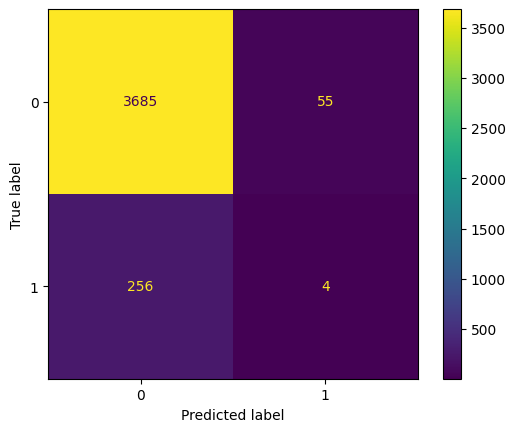

In [20]:
metrics_display(y_test, y_pred, y_pred_proba)

In [29]:
import math
import pandas as pd
from typing import Union


def metric_ppv(
    y_true: Union[list, pd.Series], 
    y_pred: Union[list, pd.Series], 
    top_p: float
) -> float:
    """
    Computes PPV at the top p% predicted probability scores.

    Args:
        y_true (Union[list, pd.Series]): Ground truth binary labels.
        y_pred (Union[list, pd.Series]): Predicted probabilities (not hard labels).
        top_p (float): Fraction (0 < top_p <= 1) of samples to include.

    Returns:
        float: Precision/PPV in the top_p most confident predictions.
    """
    if not (0 < top_p <= 1):
        raise ValueError("top_p must be between 0 and 1.")

    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must be the same length.")

    top_num = max(1, math.ceil(len(y_true) * top_p))

    ranked = pd.DataFrame({
        "label": pd.Series(y_true).values,
        "predicted_prob": pd.Series(y_pred).values,
    })

    top_ranked = ranked.sort_values("predicted_prob", ascending=False).head(top_num)
    ppv = top_ranked["label"].value_counts(normalize=True).get(1, 0.0)

    return ppv


metric_ppv(y_test, y_pred_proba, 0.05)

np.float64(0.06)